In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Предсказание сердечно-сосудистых заболеваний

Рассмотрим уже известный нам датасет и попробуем использовать деревья решений и случайный лес для предсказания наличия у пациента ССЗ. Этот подход вполне оправдан, так как мы имеем большое количество категориальных признаков, с которыми деревья хорошо работают. Затем мы сравним полученные результаты с результатами метода $kNN$.

In [ ]:
# Загружаем данные
df = pd.read_csv("../input/cardio_train.csv",sep=';')
df.head()

## Небольшая предобработка данных

1. Преобразуем признак **age**: переведём дни в годы, разделив число дней на 365.25 и округлив вниз до ближайшего целого (функция np.floor()).
2. Построим три бинарных признака на основе признака **cholesterol**, используя one hot encodeing (OHE) или dummy-кодирование.
3. Аналогично построим три бинарных признака на основе **gluc**.
4. Удалим исходные признаки **cholesterol** и **gluc**.

In [ ]:
# Предобработка
df['age'] = np.floor(df['age']/365.25) # пункт 1
new_df = pd.get_dummies(df, columns=['cholesterol','gluc']) # пункты 2, 3, 4
new_df.head()

Разделим выборку на обучающую и валидационную (тестовую) в соотношении 7:3.

In [ ]:
from sklearn.model_selection import train_test_split
X = new_df.drop('cardio', axis=1)
y = new_df['cardio']
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.3, random_state=2019) # random_state=2019

## Обучение дерева решений и настройка гиперпараметров

1. Обучим дерево решений с максимальной глубиной 3 и параметром **random_state=2019**.
2. Изобразим полученное дерево графически.
3. Сделаем предсказание с помощью полученного дерева на валидационном множестве. Вычислим метрику **accuracy** на нём.
4. Произведём подбор гиперпараметров **max_depth** и **min_samples_leaf** с помощью GridSearchCV.
5. Построим графики зависимости средней доли правильных ответов (**mean_test_score**) от значений каждого из гиперпараметров.
6. Изобразим графически полученное "оптимальное" дерево.

In [ ]:
# Обучение дерева решений
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3,random_state=2019)
tree.fit(X_train, y_train)

In [ ]:
# Визуализация
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='tree.dot')
print(open('tree.dot').read()) 
# Далее скопировать полученный текст на сайт https://dreampuf.github.io/GraphvizOnline/ и сгенерировать граф
# Вставить картинку в блокнот: ![](ссылка)

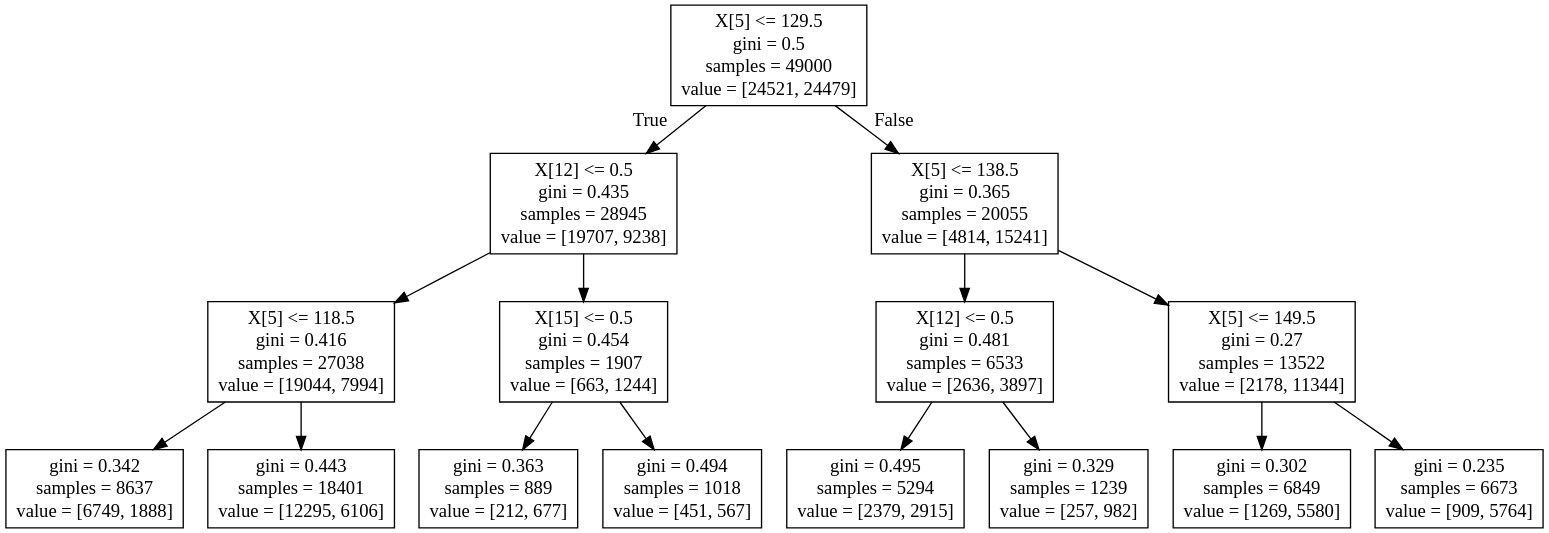

In [ ]:
# Предсказания для валидационного множества
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_valid)
accuracy_score(y_valid,y_pred)

In [ ]:
# Кросс-валидация и подбор гиперпараметров
from sklearn.model_selection import GridSearchCV

tree_params = {'max_depth': list(range(2, 11)),
               'min_samples_leaf': list(range(2, 11))}

tree_grid = GridSearchCV(tree, 
                        tree_params, 
                        scoring='accuracy',
                        cv=5) # или cv=kf
tree_grid.fit(X_train, y_train)

In [ ]:
tree_grid.best_params_

In [ ]:
tree_param1 = {'max_depth': list(range(2, 11))}

tree_grid1 = GridSearchCV(tree, 
                        tree_param1, 
                        scoring='accuracy',
                        cv=5) # или cv=kf
tree_grid1.fit(X_train, y_train)

In [ ]:
tree_param2 = {'min_samples_leaf': list(range(2, 11))}

tree_grid2 = GridSearchCV(tree, 
                        tree_param2, 
                        scoring='accuracy',
                        cv=5) # или cv=kf
tree_grid2.fit(X_train, y_train)

In [ ]:
# Отрисовка графиков
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2) # 2 графика рядом с одинаковым масштабом по оси Оу

ax[0].plot(tree_param1['max_depth'], tree_grid1.cv_results_['mean_test_score']) # accuracy vs max_depth
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('Mean accuracy on test set')

ax[1].plot(tree_param2['min_samples_leaf'], tree_grid2.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[1].set_xlabel('min_samples_leaf')
ax[1].set_ylabel('Mean accuracy on test set');

In [ ]:
best_tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, random_state=2019)
best_tree.fit(X_train, y_train)
export_graphviz(best_tree, out_file='best_tree.dot')
print(open('best_tree.dot').read()) 

In [ ]:
# Выбор и отрисовка наилучшего дерева

pd.DataFrame(tree_grid.cv_results_).head().T

best_tree = tree_grid.best_estimator_
y_pred = best_tree.predict(X_valid)
accuracy_score(y_valid, y_pred)

export_graphviz(best_tree, out_file='best_tree.dot')
print(open('best_tree.dot').read()) 
# Далее скопировать полученный текст на сайт https://dreampuf.github.io/GraphvizOnline/ и сгенерировать граф
# Вставить картинку в блокнот: ![](ссылка)

In [ ]:
accuracy_score(y_valid, y_pred)

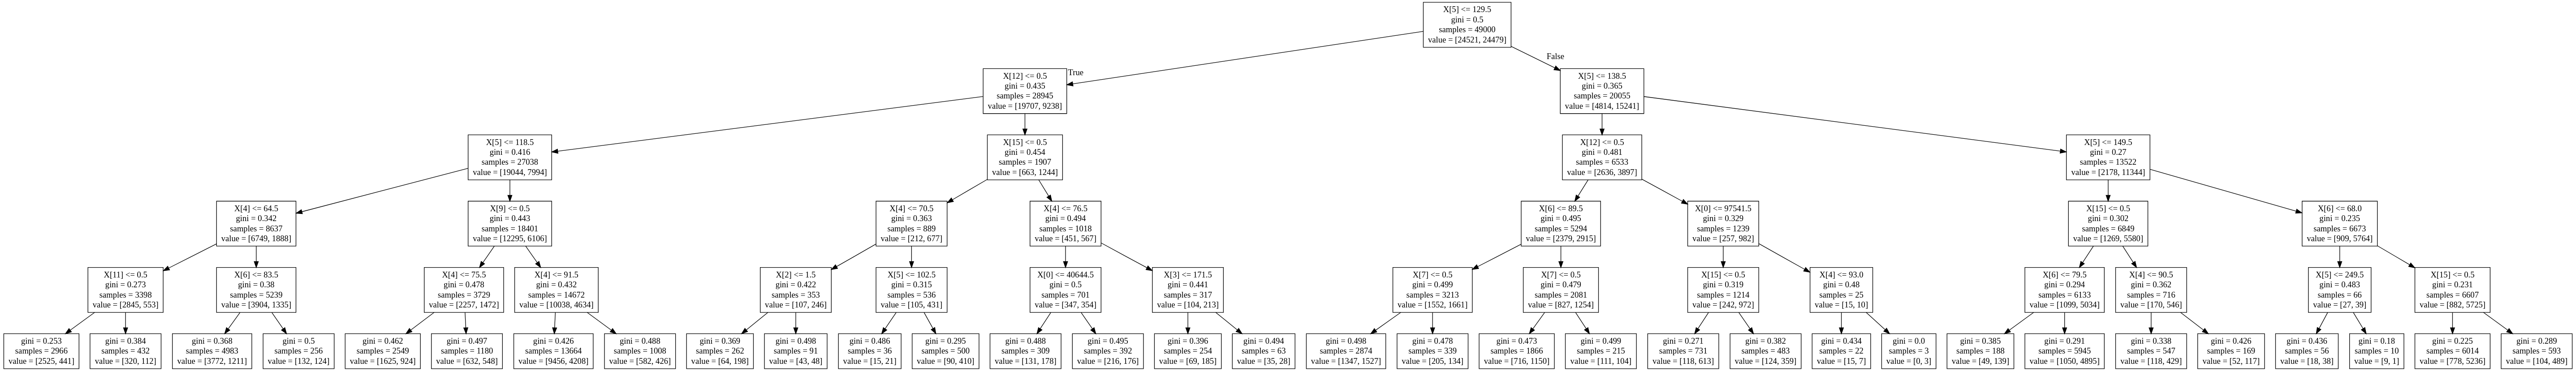

## Построение случайного леса

1. Обучите случайный лес из 100 деревьев с параметрами по умолчанию и **random_state=2019**.
2. Постройте предсказания, вычислите долю правильных ответов и сравните с метриками, полученными ранее.
3. Подберите гиперпараметры случайного леса на своё усмотрение. На сколько процентов удалось улучшить предыдущий результат?

In [ ]:
# Ваш код
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf=RandomForestClassifier(n_estimators=100, random_state=2019)
rf.fit(X_train,y_train)

In [ ]:
y_pred = rf.predict(X_valid)
accuracy_score(y_valid,y_pred)

## Метод $k$ ближайших соседей

1. Промасштабируйте признаки.
2. Обучите модель $kNN$ с евклидовым расстоянием и подбором числа соседей на кросс-валидации.
3. Сравните результаты с оптимальным деревом решений и случайным лесом.

In [ ]:
# Ваш код
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Распознавание рукописных цифр

Теперь попытаемся сравнить два подхода ($kNN$ и деревья решений) на другой задаче. Это классическая задача распознавания рукописных цифр.

Картинки представляются матрицей $8\times 8$ (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64 и получается признаковое описание объекта.

In [ ]:
# Загрузим датасет и посмотрим, как выглядят данные
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

In [ ]:
# Нарисуем несколько картинок
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 6))
for i in range(4):
    ax[i].imshow(X[i, :].reshape([8, 8]), cmap='Greys');

Разделим выборку на обучающую и тестовую.

In [ ]:
# X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=2019)

Построим модели случайного леса и $k$ ближайших соседей с какими-нибудь параметрами.

In [ ]:
from sklearn.pipeline import Pipeline

# tree = DecisionTreeClassifier(max_depth=5, random_state=2019)
# knn_pipe = Pipeline([('scaler', StandardScaler()), 
#                      ('knn', KNeighborsClassifier(n_neighbors=10))]) # мы применили "конвейер"

# tree.fit(X_train, y_train)
# knn_pipe.fit(X_train, y_train)

Оценим правильность предсказаний обеих моделей.

In [ ]:
# tree_pred = tree.predict(X_holdout)
# knn_pred = knn_pipe.predict(X_holdout)
# accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

Попробуйте настроить гиперпараметры обеих моделей. Сравните результаты до и после настройки.

In [ ]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}
knn_params = {'n_neighbors': np.arange(1, 51)}

# Ваш код